# 프로젝트: 인물 모드 문제점 찾기

### [루브릭]

1. 인물모드 사진을 성공적으로 제작하였다.   
    -아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
    
    
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.   
    -인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
    
    
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.   
    -추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.


### [학습과정]

1) 인물모드 직접 해 보기  

     * 최소 3장 이상의 인물 사진모드    
     * 인물뿐만 아니라 다른 피사체에 대한 아웃포커싱 사진 만들기  
     * 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성 시도하기  
    
    
2) 사진에서 문제점 찾기

3) 해결 방법을 제안해 보기



### [결론 및 회고]

## 1. 인물모드 직접 해 보기
---
### 1) 인물 사진모드

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import os

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/E07_HumanSegmentation/models
model loaded successfully!


### #1

(805, 499, 3)


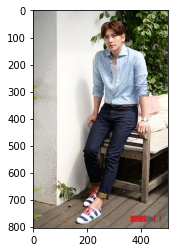

(0.0, 256.0)

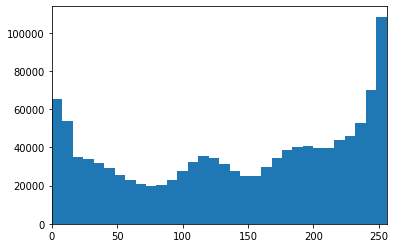

In [4]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/me1.jpg'   
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
fig, ax = plt.subplots(1, 1)
ax.hist(img_orig.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [5]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(805, 499, 3) (513, 317, 3) 16


In [6]:
# DeepLab의 PASCAL VOC 라벨

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

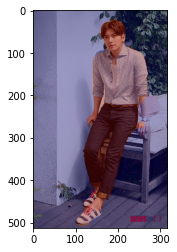

In [7]:
# 세그멘테이션

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

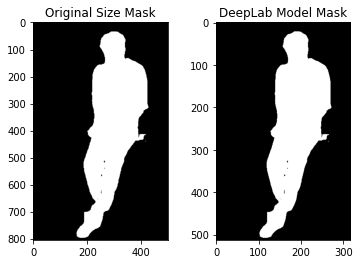

In [8]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

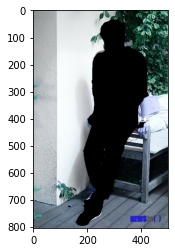

In [9]:
# 세그멘테이션 마스크를 이용하여 배경만 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)       #이미지 반전! 배경은 255, 사람이 0
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)     #배경만 있는 연산 get

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

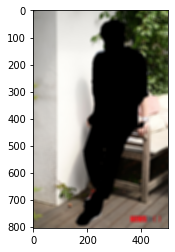

In [10]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

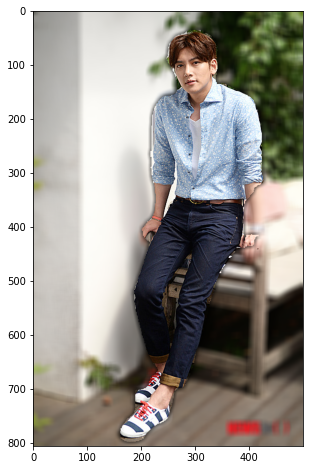

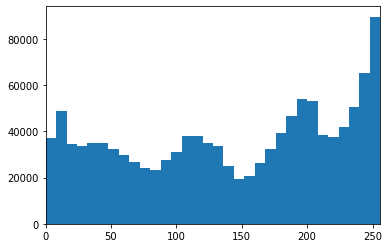

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

### #1 사진 문제점

* 다리 사이에 있는 의자도 다리와 함께 같이 인식됨
* 왼쪽 손이 부분적으로 인식되지 않음
* 경계가 명확하지 않음.

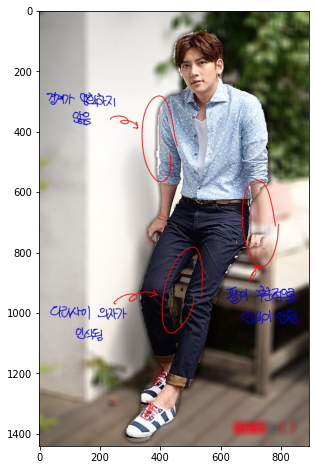

In [12]:
a1 = plt.imread('me1_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(a1)

### #2.

In [13]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/me2.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1584, 1440, 3)


In [14]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1584, 1440, 3) (513, 466, 3) 15


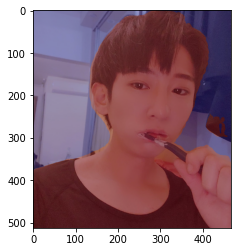

In [15]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

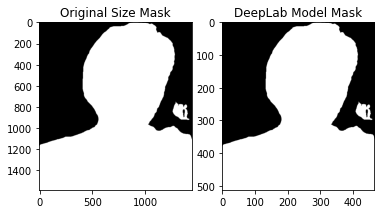

In [16]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

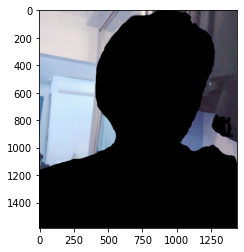

In [17]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

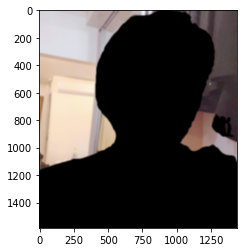

In [18]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

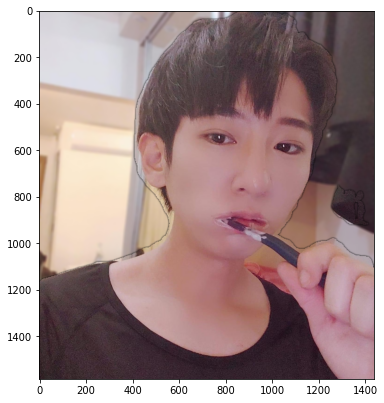

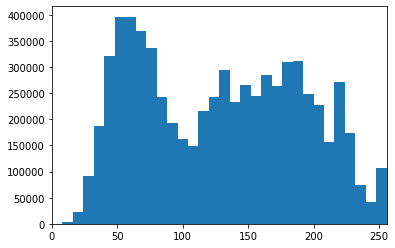

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me2_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

### #2 사진 문제점
* 전체적으로 인식이 잘 되었지만, 경계가 두껍다. 명확하게 인식되지 않음.
* 칫솔이 같이 인식됨.

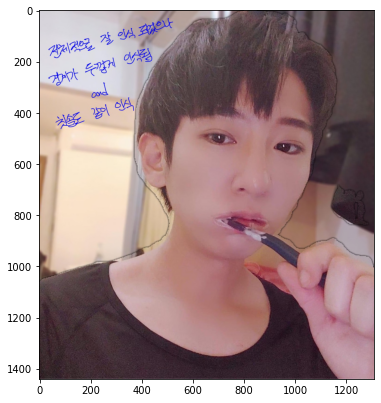

In [20]:
b1 = plt.imread('me2_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(b1)

### #3.

In [21]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/me3.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1338, 899, 3)


In [22]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1338, 899, 3) (513, 344, 3) 15


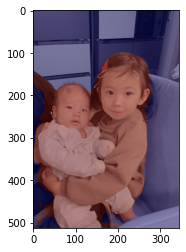

In [23]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

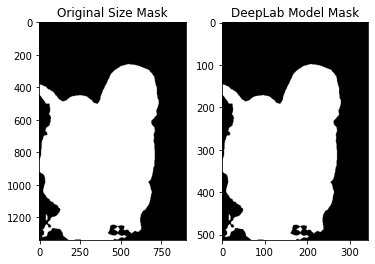

In [24]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

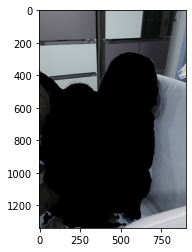

In [25]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

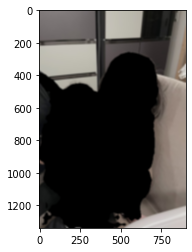

In [26]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

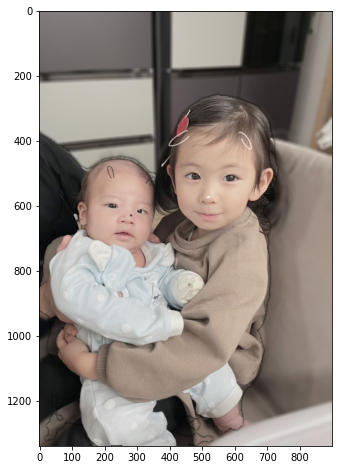

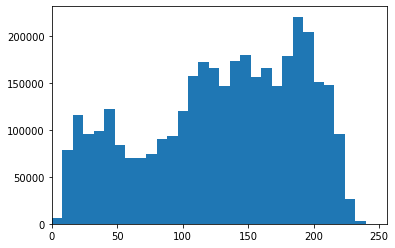

In [27]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me3_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

### #3 사진 문제점
* 딸아이의 머리카릭이 제대로 인식되지 않음 (잘려있음)
* 아들을 받치고 있는 사진 밖의 인물의 손과 어깨가 인식됨.

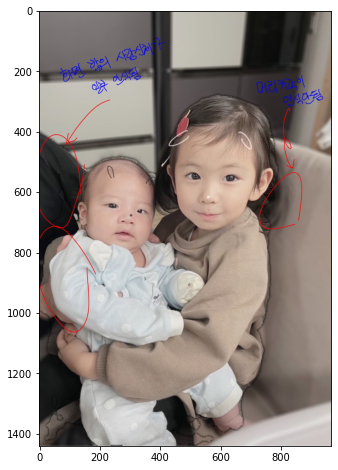

In [28]:
c1 = plt.imread('me3_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(c1)

### 2) 고양이 사진모드
### #4

In [29]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/cat.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(300, 400, 3)


In [30]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(300, 400, 3) (384, 513, 3) 8


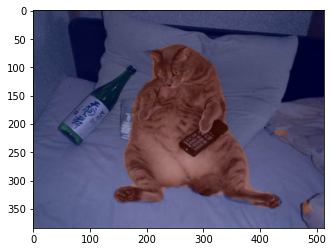

In [31]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

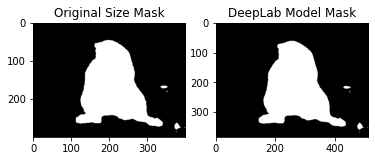

In [32]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

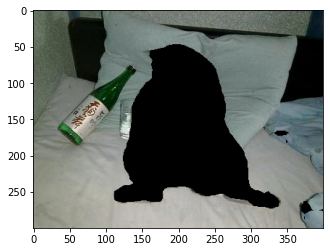

In [33]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

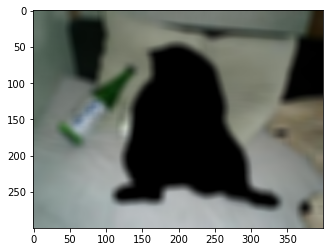

In [34]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

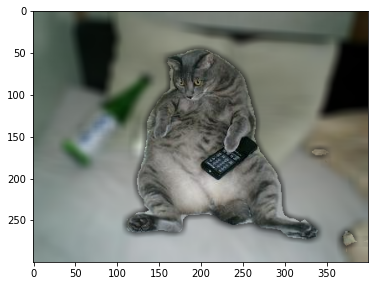

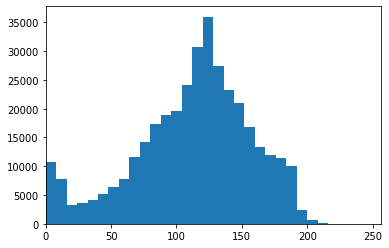

In [35]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('cat1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

고양이 모양이 이상(?)해도 잘 인식됨을 알수 있습니다

### #4 사진 문제점
* 고양이가 쥐고 있는 리모콘이 고양이 몸으로 인식되어 같이 인식됨.
* 바닥에 이유를 알 수없는 두 포인트가 인식됨..

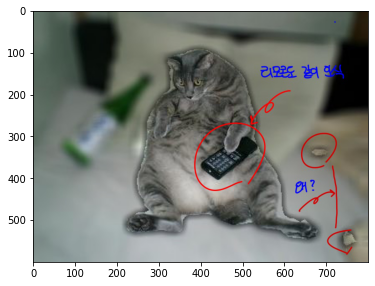

In [36]:
d1 = plt.imread('cat1_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(d1)

### #5

In [37]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/cat3.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(920, 736, 3)


In [38]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(920, 736, 3) (513, 410, 3) 8


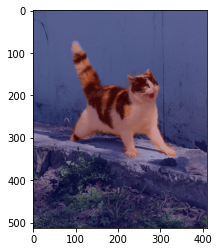

In [39]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

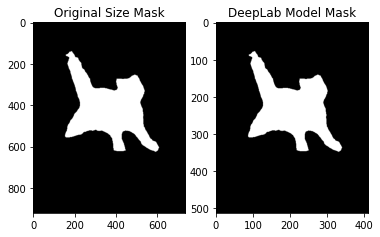

In [40]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

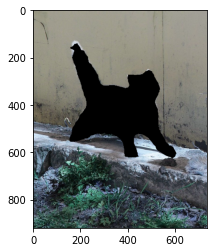

In [41]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

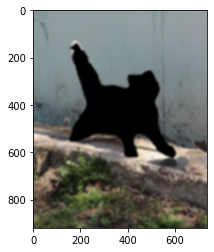

In [42]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

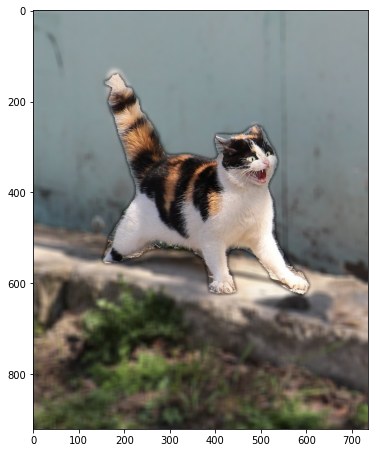

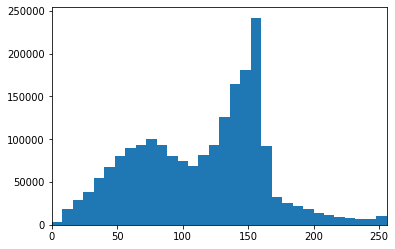

In [43]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('cat2_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

### #5 사진 문제점
* 귀 부분이 약간 잘림

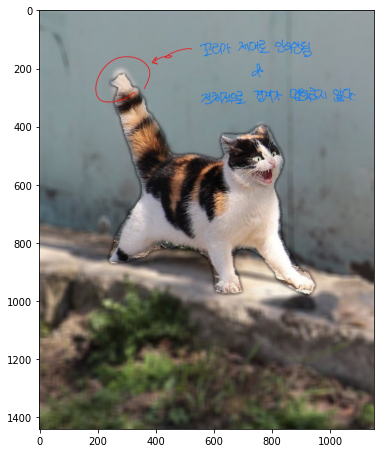

In [44]:
e1 = plt.imread('cat2_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(e1)

### 3) 크로마키 사진 

In [45]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/me3.jpg'  
img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (335, 512)) # 풍경 사이즈와 맞게 resize
print (img_orig.shape)

(512, 335, 3)


In [46]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(512, 335, 3) (513, 335, 3) 15


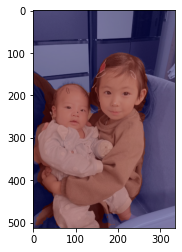

In [47]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

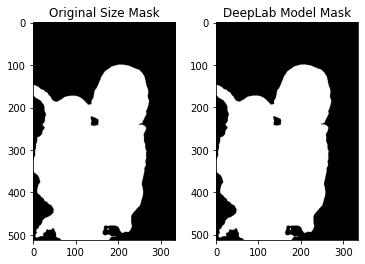

In [48]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

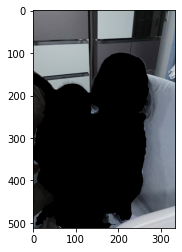

In [49]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

(512, 335, 3)


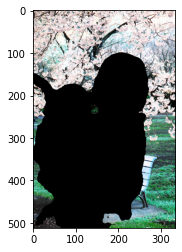

In [50]:
bg_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/풍경.jpg'  
bg_orig = cv2.imread(bg_path)
img_concat = np.where(img_bg==0, img_bg, bg_orig)
print (bg_orig.shape)
plt.imshow(img_concat)
plt.show()

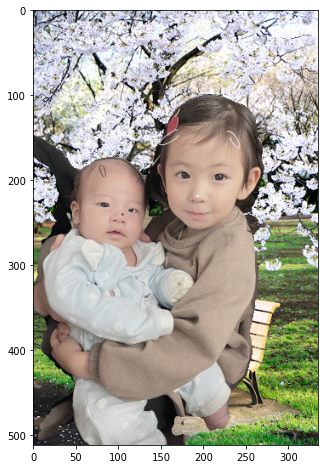

In [51]:
cromakey = np.where(img_mask_color==255, img_orig, img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(cromakey, cv2.COLOR_BGR2RGB))
plt.show()

### #2

In [52]:
img_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/cat2.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(526, 526, 3)


In [53]:
bg_path = os.getenv('HOME')+'/aiffel/E07_HumanSegmentation/images/풍경2.jpg'  
bg_orig = cv2.imread(bg_path)
print (bg_orig.shape)

(410, 512, 3)


In [54]:
img_orig = cv2.resize(img_orig, (512, 410)) # 풍경 사이즈와 맞게 resize

In [55]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(410, 512, 3) (410, 513, 3) 8


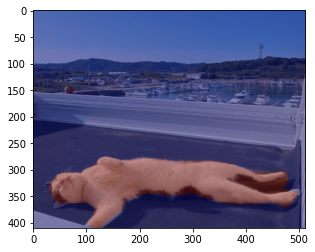

In [56]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

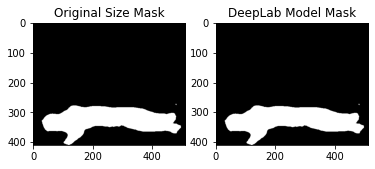

In [57]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

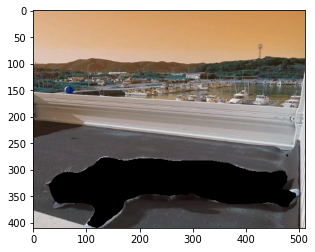

In [58]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

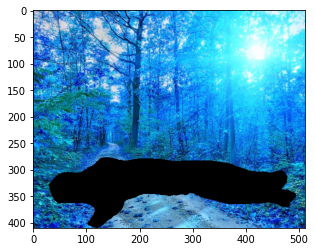

In [59]:
img_concat = np.where(img_bg==0, img_bg, bg_orig)
plt.imshow(img_concat)
plt.show()

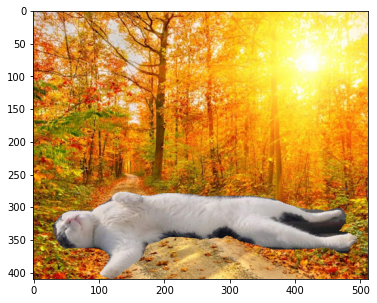

In [60]:
cromakey = np.where(img_mask_color==255, img_orig, img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(cromakey, cv2.COLOR_BGR2RGB))
plt.show()

## 인물 모드 사진의 문제점 해결 방법

인물 및 고양이 사진을 인식시켜본 결과, 대체로 잘 인식되었으나 공통적으로
* 배경과의 경계가 뚜렷하게 구분되지 않는다.
* 신체 일부가 인식이 잘 되는 경우가 있다.
* 여러 사람이 겹쳐있을 때 경계가 불명확해진다.

라는 문제가 있었습니다.   

 우리가 프로젝트를 위해 사용한 모델은 DeepLab V3+인데, DeepLab은 Semantic segmentation의 정확성을 높이기  위한 방법으로 atrous convolution을 사용합니다. 특히 V3+는 separable convolution과 atrous convolution을 결합한 atrous separable convolution을 활용하여 모델을 설계합니다.   
정확도 높은 모델을 사용하였으나 그래도 발생하는 semantic segmentation의 한계를 보완하기 위해 다음과 같은 해결 방안을 제안합니다.
 위의 문제점이 나타나는 이유는 사진이 2D이기 때문입니다. 픽셀의 depth 정보를 넣어줌으로써 Semantic segmentation의 정확성을 높일 수 있을 것입니다.
 3D camera나 센서가 없다는 가정하에, 단일 이미지마다의 depth를 예측해주는 모델을 사용하여 depth를 측정합니다. 여러 모델 중 무겁지만 성능이 좋은 mono+stereo_640x192 모델을 선택하여 depth가 반영된 이미지를 input으로 추가해줍니다.  
 아래 이미지와 같은 원리를 이용한다면, segmentation을 보완하기 위한 depth 정보를 추가함으로써 3d 이미지와 같은 output을 얻을 수 있기 때문에 경계의 부정확성이나 오차를 줄일 수 있을 것입니다.

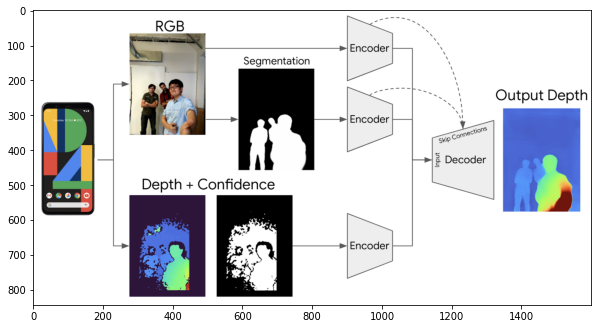

In [61]:
a = plt.imread('images/image8.png')
plt.figure(figsize=(10,8))
plt.imshow(a)

## [결과 및 회고]

이번 프로젝트에서는 DeepLabV3+ 모델을 이용해 아웃포커싱 기법이 적용된 것 같은 사진을 만들어 보았습니다. 
결과적으로, 모든 사진의 인물 및 고양이가 잘 인식되었고, 크로마키 이미지까지 생성할 수 있었습니다.   
일부러 여러 사람이 나온 사진을 선택해서 만들어봤는데, 저~ 멀리있는 사람까지 인식이 잘 돼서 좀 신기했습니다. 그리고 뭔가.. 더 전문적이고 구체적인 해결 방법을 제시하고 싶었으나 그러지 못한 것 같아 아쉽기도 합니다. 또한 인식 문제와는 별개로 사물을 잘라서 붙인 느낌이 아니라 경계선을 그린 것처럼 결과물이 나왔는데 이 부분은 어떻게 해결하면 되는지도 궁금합니다.
